 Preprocessing ground truth...


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
C:\Users\prath\AppData\Local\Temp\ipykernel_10940\837818679.py:43: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


✅ Processed adata_softimpute_imputed_mf10_run1.h5ad: Silhouette=-0.084
✅ Processed adata_softimpute_imputed_mf10_run10.h5ad: Silhouette=-0.005
✅ Processed adata_softimpute_imputed_mf10_run2.h5ad: Silhouette=-0.003
✅ Processed adata_softimpute_imputed_mf10_run3.h5ad: Silhouette=-0.017
✅ Processed adata_softimpute_imputed_mf10_run4.h5ad: Silhouette=-0.022
✅ Processed adata_softimpute_imputed_mf10_run5.h5ad: Silhouette=0.012
✅ Processed adata_softimpute_imputed_mf10_run6.h5ad: Silhouette=-0.011
✅ Processed adata_softimpute_imputed_mf10_run7.h5ad: Silhouette=-0.009
✅ Processed adata_softimpute_imputed_mf10_run8.h5ad: Silhouette=-0.010
✅ Processed adata_softimpute_imputed_mf10_run9.h5ad: Silhouette=0.012
✅ Processed adata_softimpute_imputed_mf20_run1.h5ad: Silhouette=-0.012
✅ Processed adata_softimpute_imputed_mf20_run10.h5ad: Silhouette=-0.001
✅ Processed adata_softimpute_imputed_mf20_run2.h5ad: Silhouette=-0.004
✅ Processed adata_softimpute_imputed_mf20_run3.h5ad: Silhouette=-0.003
✅ Proc

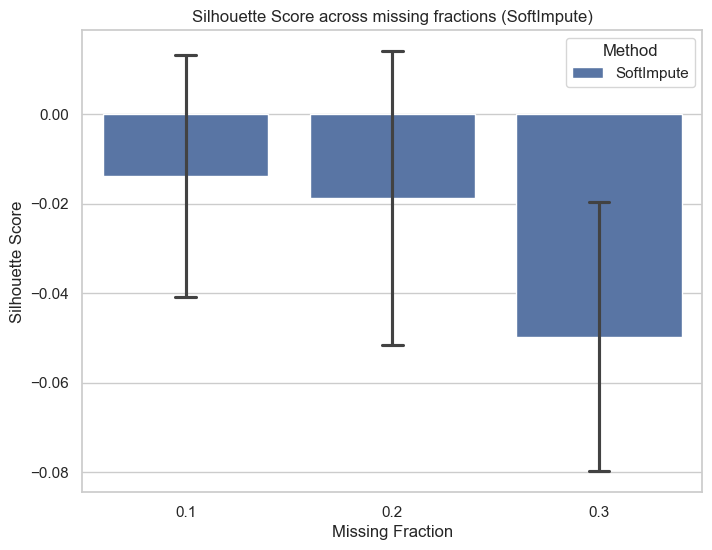

In [1]:
# Notebook 04: Performance Evaluation & Figures (SoftImpute - Silhouette)

import scanpy as sc
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# -----------------------------
# Settings
# -----------------------------
sc.settings.verbosity = 0
sns.set(style="whitegrid")

ground_truth_path = "Data/adata_raw_qc.h5ad"   # ground truth file
imputed_dir = "imputed_softimpute"             # folder with imputed h5ad files
methods = ["SoftImpute"]                       # method tag for plotting

# -----------------------------
# Preprocessing function
# -----------------------------
def preprocess_adata(adata, n_hvgs=1000):
    """Preprocess AnnData: unique names, HVGs, PCA, clustering."""
    adata = adata.copy()
    adata.obs_names_make_unique()
    adata.var_names_make_unique()

    X = adata.X.A if hasattr(adata.X, "A") else adata.X
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    adata.X = X

    if np.max(adata.X) > 30:
        sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_hvgs)
    adata = adata[:, adata.var["highly_variable"]].copy()

    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata

# -----------------------------
# Load ground truth
# -----------------------------
print(" Preprocessing ground truth...")
adata_gt = sc.read_h5ad(ground_truth_path)
adata_gt = preprocess_adata(adata_gt)

if "leiden" not in adata_gt.obs:
    raise ValueError("Ground truth AnnData does not have 'leiden' clustering.")

# -----------------------------
# Helper: Silhouette
# -----------------------------
def compute_silhouette(adata):
    """Compute silhouette score using PCA coordinates and leiden labels."""
    try:
        score = silhouette_score(adata.obsm["X_pca"], adata.obs["leiden"])
    except Exception:
        score = np.nan
    return score

# -----------------------------
# Evaluate imputation runs
# -----------------------------
results = []

for fname in os.listdir(imputed_dir):
    if not fname.endswith(".h5ad"):
        continue

    fpath = os.path.join(imputed_dir, fname)
    try:
        adata_imp = sc.read_h5ad(fpath)
        adata_imp = preprocess_adata(adata_imp)

        # Align cells
        common_cells = adata_gt.obs_names.intersection(adata_imp.obs_names)
        adata_imp_sub = adata_imp[common_cells]

        # Compute Silhouette
        sil = compute_silhouette(adata_imp_sub)

        # Parse metadata (mfXX, runX)
        mf, run = None, None
        for part in fname.split("_"):
            if part.startswith("mf"):
                mf = float(part.replace("mf", "").replace(".h5ad", "")) / 100
            if part.startswith("run"):
                run = int(part.replace("run", "").replace(".h5ad", ""))

        results.append({
            "file": fname,
            "method": "SoftImpute",
            "Silhouette": sil,
            "missing_fraction": mf,
            "run": run
        })

        print(f"✅ Processed {fname}: Silhouette={sil:.3f}")

    except Exception as e:
        print(f"❌ Error with {fname}: {e}")

# -----------------------------
# Results → DataFrame
# -----------------------------
results_df = pd.DataFrame(results)

if results_df.empty:
    raise ValueError("No results computed. Check your imputed files and pipeline.")

results_df = results_df.dropna(subset=["Silhouette", "missing_fraction"])
results_df["missing_fraction"] = results_df["missing_fraction"].astype(float)

# -----------------------------
# Summary
# -----------------------------
summary = results_df.groupby(["method", "missing_fraction"]).agg(
    Silhouette_mean=("Silhouette", "mean"),
    Silhouette_std=("Silhouette", "std"),
    runs=("Silhouette", "count")
).reset_index()

print("\nSummary (mean ± std):")
print(summary)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8, 6))
sns.barplot(
    data=results_df,
    x="missing_fraction",
    y="Silhouette",
    hue="method",
    errorbar="sd",
    capsize=0.1
)
plt.title("Silhouette Score across missing fractions (SoftImpute)")
plt.ylabel("Silhouette Score")
plt.xlabel("Missing Fraction")
plt.legend(title="Method")
plt.show()


 Preprocessing ground truth...


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicat

✅ Processed adata_magic_imputed_mf10_run1.h5ad: Silhouette=0.281


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf10_run10.h5ad: Silhouette=0.220


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf10_run2.h5ad: Silhouette=0.254


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf10_run3.h5ad: Silhouette=0.256


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf10_run4.h5ad: Silhouette=0.237


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf10_run5.h5ad: Silhouette=0.186


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf10_run6.h5ad: Silhouette=0.267


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf10_run7.h5ad: Silhouette=0.213


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf10_run8.h5ad: Silhouette=0.229


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf10_run9.h5ad: Silhouette=0.257


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf20_run1.h5ad: Silhouette=0.194


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf20_run10.h5ad: Silhouette=0.164


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf20_run2.h5ad: Silhouette=0.156


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf20_run3.h5ad: Silhouette=0.168


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf20_run4.h5ad: Silhouette=0.195


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf20_run5.h5ad: Silhouette=0.175


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf20_run6.h5ad: Silhouette=0.204


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf20_run7.h5ad: Silhouette=0.221


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf20_run8.h5ad: Silhouette=0.187


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf20_run9.h5ad: Silhouette=0.197


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf30_run1.h5ad: Silhouette=0.182


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf30_run10.h5ad: Silhouette=0.180


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf30_run2.h5ad: Silhouette=0.147


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf30_run3.h5ad: Silhouette=0.157


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf30_run4.h5ad: Silhouette=0.167


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf30_run5.h5ad: Silhouette=0.135


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf30_run6.h5ad: Silhouette=0.124


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf30_run7.h5ad: Silhouette=0.171


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf30_run8.h5ad: Silhouette=0.180


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✅ Processed adata_magic_imputed_mf30_run9.h5ad: Silhouette=0.153

Summary (mean ± std):
  method  missing_fraction  Silhouette_mean  Silhouette_std  runs
0  magic               0.1         0.239937        0.028426    10
1  magic               0.2         0.186110        0.019970    10
2  magic               0.3         0.159470        0.020136    10


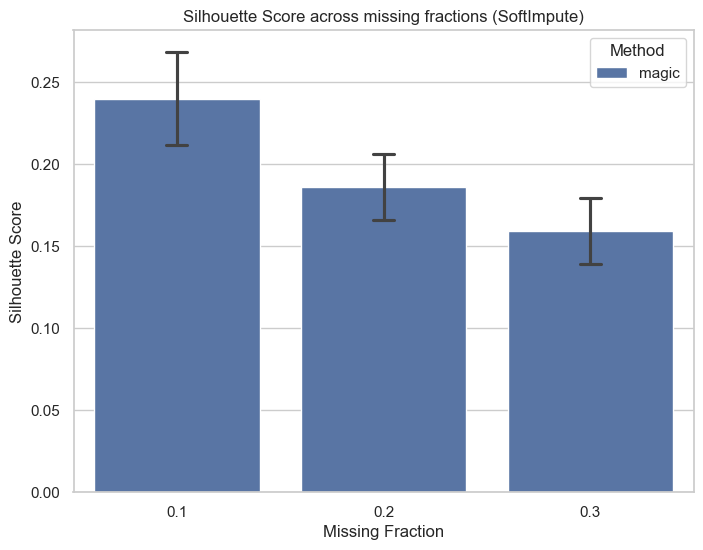

In [2]:

import scanpy as sc
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# -----------------------------
# Settings
# -----------------------------
sc.settings.verbosity = 0
sns.set(style="whitegrid")

ground_truth_path = "Data/adata_raw_qc.h5ad"   # ground truth file
imputed_dir = "imputed_h5ad"             # folder with imputed h5ad files
methods = ["magic"]                       # method tag for plotting

# -----------------------------
# Preprocessing function
# -----------------------------
def preprocess_adata(adata, n_hvgs=1000):
    """Preprocess AnnData: unique names, HVGs, PCA, clustering."""
    adata = adata.copy()
    adata.obs_names_make_unique()
    adata.var_names_make_unique()

    X = adata.X.A if hasattr(adata.X, "A") else adata.X
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    adata.X = X

    if np.max(adata.X) > 30:
        sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_hvgs)
    adata = adata[:, adata.var["highly_variable"]].copy()

    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata

# -----------------------------
# Load ground truth
# -----------------------------
print(" Preprocessing ground truth...")
adata_gt = sc.read_h5ad(ground_truth_path)
adata_gt = preprocess_adata(adata_gt)

if "leiden" not in adata_gt.obs:
    raise ValueError("Ground truth AnnData does not have 'leiden' clustering.")

# -----------------------------
# Helper: Silhouette
# -----------------------------
def compute_silhouette(adata):
    """Compute silhouette score using PCA coordinates and leiden labels."""
    try:
        score = silhouette_score(adata.obsm["X_pca"], adata.obs["leiden"])
    except Exception:
        score = np.nan
    return score

# -----------------------------
# Evaluate imputation runs
# -----------------------------
results = []

for fname in os.listdir(imputed_dir):
    if not fname.endswith(".h5ad"):
        continue

    fpath = os.path.join(imputed_dir, fname)
    try:
        adata_imp = sc.read_h5ad(fpath)
        adata_imp = preprocess_adata(adata_imp)

        # Align cells
        common_cells = adata_gt.obs_names.intersection(adata_imp.obs_names)
        adata_imp_sub = adata_imp[common_cells]

        # Compute Silhouette
        sil = compute_silhouette(adata_imp_sub)

        # Parse metadata (mfXX, runX)
        mf, run = None, None
        for part in fname.split("_"):
            if part.startswith("mf"):
                mf = float(part.replace("mf", "").replace(".h5ad", "")) / 100
            if part.startswith("run"):
                run = int(part.replace("run", "").replace(".h5ad", ""))

        results.append({
            "file": fname,
            "method": "magic",
            "Silhouette": sil,
            "missing_fraction": mf,
            "run": run
        })

        print(f"✅ Processed {fname}: Silhouette={sil:.3f}")

    except Exception as e:
        print(f"Error with {fname}: {e}")

# -----------------------------
# Results → DataFrame
# -----------------------------
results_df = pd.DataFrame(results)

if results_df.empty:
    raise ValueError("No results computed. Check your imputed files and pipeline.")

results_df = results_df.dropna(subset=["Silhouette", "missing_fraction"])
results_df["missing_fraction"] = results_df["missing_fraction"].astype(float)

# -----------------------------
# Summary
# -----------------------------
summary = results_df.groupby(["method", "missing_fraction"]).agg(
    Silhouette_mean=("Silhouette", "mean"),
    Silhouette_std=("Silhouette", "std"),
    runs=("Silhouette", "count")
).reset_index()

print("\nSummary (mean ± std):")
print(summary)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(8, 6))
sns.barplot(
    data=results_df,
    x="missing_fraction",
    y="Silhouette",
    hue="method",
    errorbar="sd",
    capsize=0.1
)
plt.title("Silhouette Score across missing fractions (SoftImpute)")
plt.ylabel("Silhouette Score")
plt.xlabel("Missing Fraction")
plt.legend(title="Method")
plt.show()


 Preprocessing ground truth...


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


SoftImpute - adata_softimpute_imputed_mf10_run1.h5ad: Silhouette=-0.084
SoftImpute - adata_softimpute_imputed_mf10_run10.h5ad: Silhouette=-0.005
SoftImpute - adata_softimpute_imputed_mf10_run2.h5ad: Silhouette=-0.003
SoftImpute - adata_softimpute_imputed_mf10_run3.h5ad: Silhouette=-0.017
SoftImpute - adata_softimpute_imputed_mf10_run4.h5ad: Silhouette=-0.022
SoftImpute - adata_softimpute_imputed_mf10_run5.h5ad: Silhouette=0.012
SoftImpute - adata_softimpute_imputed_mf10_run6.h5ad: Silhouette=-0.011
SoftImpute - adata_softimpute_imputed_mf10_run7.h5ad: Silhouette=-0.009
SoftImpute - adata_softimpute_imputed_mf10_run8.h5ad: Silhouette=-0.010
SoftImpute - adata_softimpute_imputed_mf10_run9.h5ad: Silhouette=0.012
SoftImpute - adata_softimpute_imputed_mf20_run1.h5ad: Silhouette=-0.012
SoftImpute - adata_softimpute_imputed_mf20_run10.h5ad: Silhouette=-0.001
SoftImpute - adata_softimpute_imputed_mf20_run2.h5ad: Silhouette=-0.004
SoftImpute - adata_softimpute_imputed_mf20_run3.h5ad: Silhouette

c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf10_run1.h5ad: Silhouette=0.281


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf10_run10.h5ad: Silhouette=0.220


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf10_run2.h5ad: Silhouette=0.254


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf10_run3.h5ad: Silhouette=0.256


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf10_run4.h5ad: Silhouette=0.237


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf10_run5.h5ad: Silhouette=0.186


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf10_run6.h5ad: Silhouette=0.267


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf10_run7.h5ad: Silhouette=0.213


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf10_run8.h5ad: Silhouette=0.229


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf10_run9.h5ad: Silhouette=0.257


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf20_run1.h5ad: Silhouette=0.194


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf20_run10.h5ad: Silhouette=0.164


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf20_run2.h5ad: Silhouette=0.156


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf20_run3.h5ad: Silhouette=0.168


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf20_run4.h5ad: Silhouette=0.195


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf20_run5.h5ad: Silhouette=0.175


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf20_run6.h5ad: Silhouette=0.204


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf20_run7.h5ad: Silhouette=0.221


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf20_run8.h5ad: Silhouette=0.187


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf20_run9.h5ad: Silhouette=0.197


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf30_run1.h5ad: Silhouette=0.182


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf30_run10.h5ad: Silhouette=0.180


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf30_run2.h5ad: Silhouette=0.147


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf30_run3.h5ad: Silhouette=0.157


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf30_run4.h5ad: Silhouette=0.167


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf30_run5.h5ad: Silhouette=0.135


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf30_run6.h5ad: Silhouette=0.124


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf30_run7.h5ad: Silhouette=0.171


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf30_run8.h5ad: Silhouette=0.180


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


MAGIC - adata_magic_imputed_mf30_run9.h5ad: Silhouette=0.153


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf10_run1.h5ad: Silhouette=0.046


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf10_run10.h5ad: Silhouette=0.121


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf10_run2.h5ad: Silhouette=0.114


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf10_run3.h5ad: Silhouette=0.092


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf10_run4.h5ad: Silhouette=0.108


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf10_run5.h5ad: Silhouette=0.104


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf10_run6.h5ad: Silhouette=0.107


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf10_run7.h5ad: Silhouette=0.085


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf10_run8.h5ad: Silhouette=0.094


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf10_run9.h5ad: Silhouette=0.074


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf20_run1.h5ad: Silhouette=0.036


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf20_run10.h5ad: Silhouette=0.054
KNN - adata_knn_imputed_mf20_run2.h5ad: Silhouette=-0.014


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf20_run3.h5ad: Silhouette=0.029
KNN - adata_knn_imputed_mf20_run4.h5ad: Silhouette=0.072


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf20_run5.h5ad: Silhouette=0.052


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf20_run6.h5ad: Silhouette=0.036


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf20_run7.h5ad: Silhouette=0.067


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf20_run8.h5ad: Silhouette=-0.008


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


KNN - adata_knn_imputed_mf20_run9.h5ad: Silhouette=0.068
KNN - adata_knn_imputed_mf30_run1.h5ad: Silhouette=-0.046
KNN - adata_knn_imputed_mf30_run10.h5ad: Silhouette=-0.043
KNN - adata_knn_imputed_mf30_run2.h5ad: Silhouette=0.029
KNN - adata_knn_imputed_mf30_run3.h5ad: Silhouette=-0.037
KNN - adata_knn_imputed_mf30_run4.h5ad: Silhouette=-0.025
KNN - adata_knn_imputed_mf30_run5.h5ad: Silhouette=-0.037
KNN - adata_knn_imputed_mf30_run6.h5ad: Silhouette=-0.019
KNN - adata_knn_imputed_mf30_run7.h5ad: Silhouette=-0.042
KNN - adata_knn_imputed_mf30_run8.h5ad: Silhouette=-0.026
KNN - adata_knn_imputed_mf30_run9.h5ad: Silhouette=-0.030


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf10_run1.h5ad: Silhouette=-0.066


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf10_run10.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf10_run2.h5ad: Silhouette=-0.084


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf10_run3.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf10_run4.h5ad: Silhouette=-0.079


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf10_run5.h5ad: Silhouette=-0.079


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf10_run6.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf10_run7.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf10_run8.h5ad: Silhouette=-0.075


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf10_run9.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf20_run1.h5ad: Silhouette=-0.074


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf20_run10.h5ad: Silhouette=-0.071


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf20_run2.h5ad: Silhouette=-0.077


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf20_run3.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf20_run4.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf20_run5.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf20_run6.h5ad: Silhouette=-0.084


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf20_run7.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf20_run8.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf20_run9.h5ad: Silhouette=-0.112


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf30_run1.h5ad: Silhouette=-0.077


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf30_run10.h5ad: Silhouette=-0.111


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf30_run2.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf30_run3.h5ad: Silhouette=-0.081


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf30_run4.h5ad: Silhouette=-0.088


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf30_run5.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf30_run6.h5ad: Silhouette=-0.086


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Mean - adata_mean_imputed_mf30_run7.h5ad: Silhouette=-0.063


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf30_run8.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\_utils\__init__.py:565: RuntimeWarning: overflow encountered in multiply
  return x * y
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_scale.py:199: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var)


Error with Mean - adata_mean_imputed_mf30_run9.h5ad: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf10_run1.h5ad: Silhouette=-0.135


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf10_run10.h5ad: Silhouette=-0.143


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf10_run2.h5ad: Silhouette=-0.083


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf10_run3.h5ad: Silhouette=-0.125


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf10_run4.h5ad: Silhouette=-0.138


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf10_run5.h5ad: Silhouette=-0.154


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf10_run6.h5ad: Silhouette=-0.141


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf10_run7.h5ad: Silhouette=-0.135


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf10_run8.h5ad: Silhouette=-0.131


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf10_run9.h5ad: Silhouette=-0.142


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf20_run1.h5ad: Silhouette=-0.155


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf20_run10.h5ad: Silhouette=-0.162


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf20_run2.h5ad: Silhouette=-0.167


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf20_run3.h5ad: Silhouette=-0.150


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf20_run4.h5ad: Silhouette=-0.142


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf20_run5.h5ad: Silhouette=-0.165


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf20_run6.h5ad: Silhouette=-0.162


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf20_run7.h5ad: Silhouette=-0.154


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf20_run8.h5ad: Silhouette=-0.145


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf20_run9.h5ad: Silhouette=-0.166


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf30_run1.h5ad: Silhouette=-0.160


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf30_run10.h5ad: Silhouette=-0.140


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf30_run2.h5ad: Silhouette=-0.147


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf30_run3.h5ad: Silhouette=-0.133


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf30_run4.h5ad: Silhouette=-0.162


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf30_run5.h5ad: Silhouette=-0.141


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf30_run6.h5ad: Silhouette=-0.159


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf30_run7.h5ad: Silhouette=-0.161


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf30_run8.h5ad: Silhouette=-0.146


c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\prath\anaconda-new\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\prath\anaconda-new\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


GAN - adata_adata_gan_imputed_mf30_run9.h5ad: Silhouette=-0.156


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf10_run1.h5ad: Silhouette=0.025


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf10_run10.h5ad: Silhouette=0.114


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf10_run2.h5ad: Silhouette=0.056


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf10_run3.h5ad: Silhouette=0.088


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf10_run4.h5ad: Silhouette=0.044


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf10_run5.h5ad: Silhouette=0.052


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf10_run6.h5ad: Silhouette=0.104


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf10_run7.h5ad: Silhouette=0.090


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf10_run8.h5ad: Silhouette=0.040


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf10_run9.h5ad: Silhouette=0.076


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf20_run1.h5ad: Silhouette=0.064


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf20_run10.h5ad: Silhouette=0.055
Iterative - adata_iterative_imputed_mf20_run2.h5ad: Silhouette=0.064


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf20_run3.h5ad: Silhouette=-0.012
Iterative - adata_iterative_imputed_mf20_run4.h5ad: Silhouette=0.046


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf20_run5.h5ad: Silhouette=0.066


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf20_run6.h5ad: Silhouette=0.066


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf20_run7.h5ad: Silhouette=0.031


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf20_run8.h5ad: Silhouette=-0.027


c:\Users\prath\anaconda-new\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Iterative - adata_iterative_imputed_mf20_run9.h5ad: Silhouette=-0.023
Iterative - adata_iterative_imputed_mf30_run1.h5ad: Silhouette=-0.044
Iterative - adata_iterative_imputed_mf30_run10.h5ad: Silhouette=-0.035
Iterative - adata_iterative_imputed_mf30_run2.h5ad: Silhouette=0.040
Iterative - adata_iterative_imputed_mf30_run3.h5ad: Silhouette=0.074
Iterative - adata_iterative_imputed_mf30_run4.h5ad: Silhouette=0.027
Iterative - adata_iterative_imputed_mf30_run5.h5ad: Silhouette=-0.028
Iterative - adata_iterative_imputed_mf30_run6.h5ad: Silhouette=-0.014
Iterative - adata_iterative_imputed_mf30_run7.h5ad: Silhouette=0.033
Iterative - adata_iterative_imputed_mf30_run8.h5ad: Silhouette=0.051
Iterative - adata_iterative_imputed_mf30_run9.h5ad: Silhouette=0.012


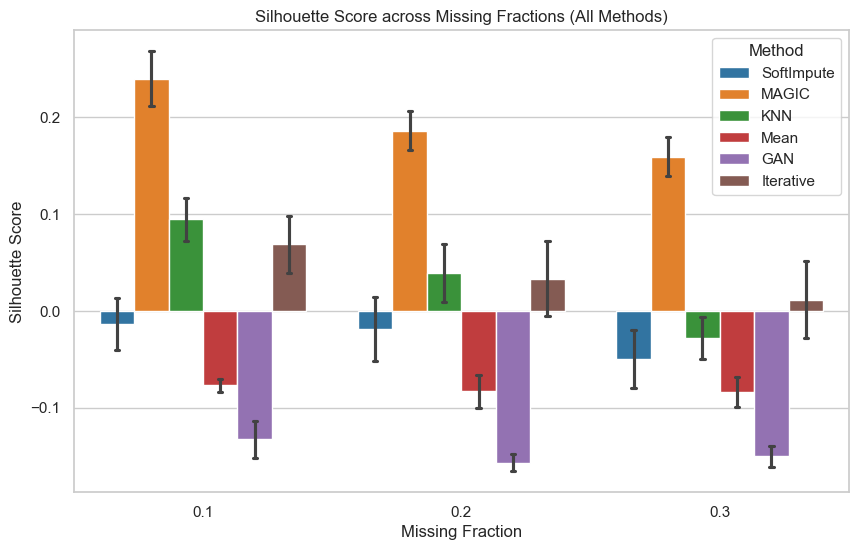

In [4]:
# Notebook 04: Performance Evaluation & Figures (All Methods - Silhouette)

import scanpy as sc
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# -----------------------------
# Settings
# -----------------------------
sc.settings.verbosity = 0
sns.set(style="whitegrid")

ground_truth_path = "Data/adata_raw_qc.h5ad"   # ground truth file

# folders for each method
imputed_dirs = {
    "SoftImpute": "imputed_softimpute",
    "MAGIC": "imputed_h5ad",
    "KNN": "imputed_knn",
    "Mean": "imputed_mean",
    "GAN": "imputed_gan",
    "Iterative": "imputed_iterative"
}

# -----------------------------
# Preprocessing function
# -----------------------------
def preprocess_adata(adata, n_hvgs=1000):
    adata = adata.copy()
    adata.obs_names_make_unique()
    adata.var_names_make_unique()

    X = adata.X.A if hasattr(adata.X, "A") else adata.X
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    adata.X = X

    if np.max(adata.X) > 30:
        sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_hvgs)
    adata = adata[:, adata.var["highly_variable"]].copy()

    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)
    return adata

# -----------------------------
# Load ground truth
# -----------------------------
print(" Preprocessing ground truth...")
adata_gt = sc.read_h5ad(ground_truth_path)
adata_gt = preprocess_adata(adata_gt)

if "leiden" not in adata_gt.obs:
    raise ValueError("Ground truth AnnData does not have 'leiden' clustering.")

# -----------------------------
# Helper: Silhouette
# -----------------------------
def compute_silhouette(adata):
    try:
        score = silhouette_score(adata.obsm["X_pca"], adata.obs["leiden"])
    except Exception:
        score = np.nan
    return score

# -----------------------------
# Evaluate all methods
# -----------------------------
results = []

for method, imputed_dir in imputed_dirs.items():
    if not os.path.exists(imputed_dir):
        print(f"⚠️ Skipping {method}, folder not found: {imputed_dir}")
        continue

    for fname in os.listdir(imputed_dir):
        if not fname.endswith(".h5ad"):
            continue

        fpath = os.path.join(imputed_dir, fname)
        try:
            adata_imp = sc.read_h5ad(fpath)
            adata_imp = preprocess_adata(adata_imp)

            # Align cells
            common_cells = adata_gt.obs_names.intersection(adata_imp.obs_names)
            adata_imp_sub = adata_imp[common_cells]

            # Compute Silhouette
            sil = compute_silhouette(adata_imp_sub)

            # Parse metadata (mfXX, runX)
            mf, run = None, None
            for part in fname.split("_"):
                if part.startswith("mf"):
                    mf = float(part.replace("mf", "").replace(".h5ad", "")) / 100
                if part.startswith("run"):
                    run = int(part.replace("run", "").replace(".h5ad", ""))

            results.append({
                "file": fname,
                "method": method,
                "Silhouette": sil,
                "missing_fraction": mf,
                "run": run
            })

            print(f"{method} - {fname}: Silhouette={sil:.3f}")

        except Exception as e:
            print(f"Error with {method} - {fname}: {e}")

# -----------------------------
# Results → DataFrame
# -----------------------------
results_df = pd.DataFrame(results)

if results_df.empty:
    raise ValueError("No results computed. Check your imputed files and pipeline.")

results_df = results_df.dropna(subset=["Silhouette", "missing_fraction"])
results_df["missing_fraction"] = results_df["missing_fraction"].astype(float)

# -----------------------------
# Plot all methods with palette
# -----------------------------
palette = {
    "SoftImpute": "#1f77b4",   # blue
    "MAGIC": "#ff7f0e",        # orange
    "KNN": "#2ca02c",          # green
    "Mean": "#d62728",         # red
    "GAN": "#9467bd",          # purple
    "Iterative": "#8c564b"     # brown
}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df,
    x="missing_fraction",
    y="Silhouette",
    hue="method",
    errorbar="sd",
    capsize=0.1,
    palette=palette
)
plt.title("Silhouette Score across Missing Fractions (All Methods)")
plt.ylabel("Silhouette Score")
plt.xlabel("Missing Fraction")
plt.legend(title="Method")
plt.show()
